In [2]:
# Install the packages if necessary
#install.packages("devtools")
#install.packages("bgsmtr")
#install.packages("corrplot")
#install.packages("pheatmap")
#install.packages('coefplot')
#library(devtools)
#install.packages('glinternet')
require(glinternet)
library(glmnet)
library(corrplot)
#library(pheatmap)
library(tidyverse)
library(coefplot)
library(cowplot)
#install_github("monogenea/gflasso")
#install.packages('glmnet')

IDs 3, 4, 69 and 87 do not have any data from visit 3. These participants were excluded from analyses at visit 3 because they did not complete the fully controlled diet intervention period. 

In the PlosOne paper (where only group 1 and 3 were analyzed), 2 additional participants that were found to be outliers were excluded. Stine and I were wondering if, based on your analyses, you find any participants that are outliers and therefore should be excluded? 

In [3]:
dat = read.table('./dataset/data_total.csv',dec=',',sep=';',header=T)

In [5]:
table(dat$visit)


 2  3  4 
54 54 54 

In [5]:
#subset data to include visit2 and 3 only
dat %>% filter(visit!=4) -> dat_sub
#remove IDs 3, 4, 69 and 87 for non-compliant reason
dat_sub %>% filter(!(id %in% c(3, 4, 58, 69, 87))) -> dat_sub
dat_sub$visit <- dat_sub$visit %>% type.convert()
dat_sub$group <- dat_sub$group %>% type.convert()
dat_sub$sex <- dat_sub$sex %>% type.convert()

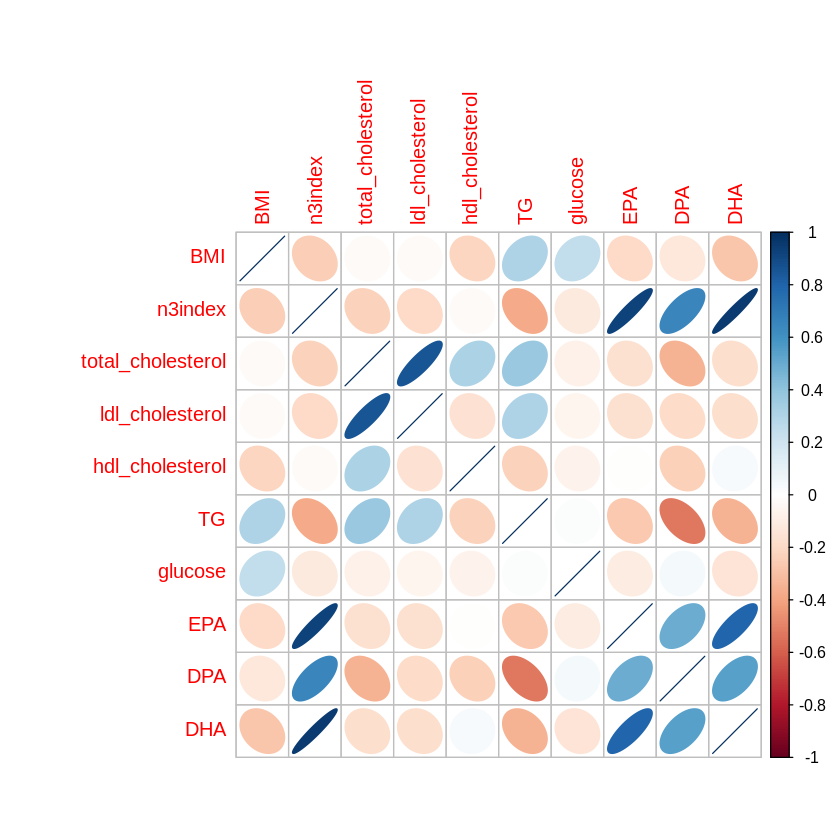

In [7]:
z = as.matrix(dat_sub[,7:16])
corrplot(cor(z,use='pairwise.complete.obs'),method='ellipse')

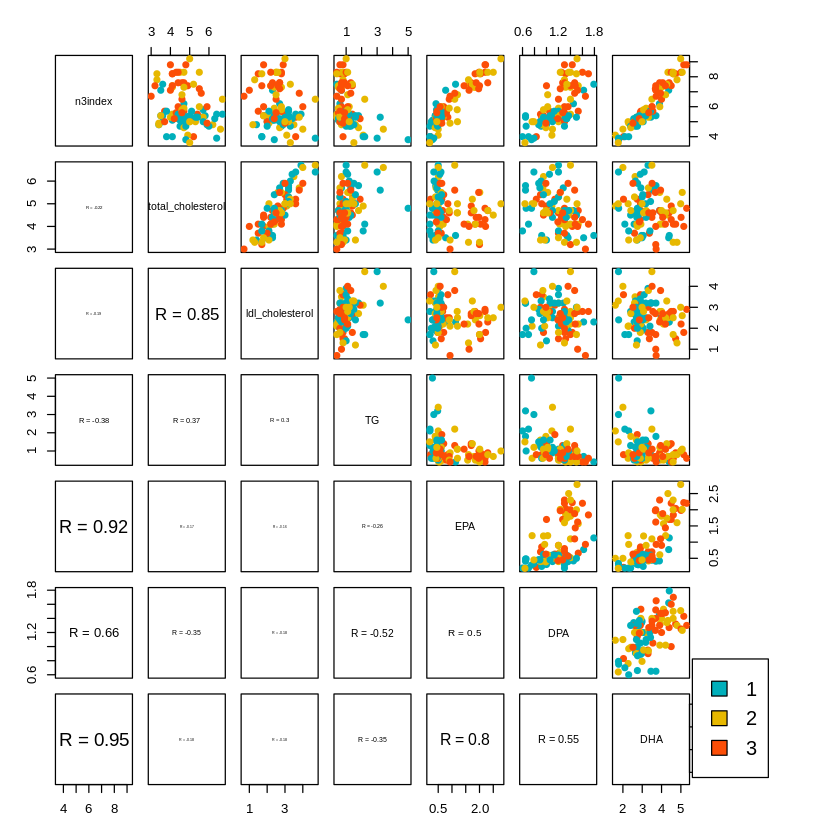

In [8]:
# visual inspection of the observation by group
my_cols <- c("#00AFBB", "#E7B800", "#FC4E07")
panel.cor <- function(x, y){
    usr <- par("usr"); on.exit(par(usr))
    par(usr = c(0, 1, 0, 1))
    r <- round(cor(x, y), digits=2)
    txt <- paste0("R = ", r)
    cex.cor <- 1.5
    text(0.5, 0.5, txt, cex = abs(cex.cor * r))
}
# Customize upper panel
upper.panel<-function(x, y){
  points(x,y, pch = 19, col = my_cols[as.factor(dat_sub$group)])
}
# Create the plots
pairs(~n3index + total_cholesterol + ldl_cholesterol + TG + EPA + DPA + DHA, 
        dat_sub ,lower.panel = panel.cor,
        upper.panel = upper.panel, oma=c(3,3,3,9))
par(xpd=TRUE)
legend("bottomright", legend = as.vector(unique(dat_sub$group)),  
    fill=my_cols)


In [10]:
# Run lasso with each clinical parameter as y

# Create subset for each visit on the new dataset
dat.visit2 = subset(dat_sub, subset=(visit==2))
dat.visit3 = subset(dat_sub, subset=(visit==3))

# Create dummy var. for each trt, constrasting the control
dat.visit3$trt1 <- ifelse(dat.visit3$group == 2, 1, 0)
dat.visit3$trt2 <- ifelse(dat.visit3$group == 3, 1, 0)
dat.visit3$trt = dat.visit3$group
#dat.visit3$trt[dat.visit3$group>1] = 1
#dat.visit3$trt[dat.visit3$group==1] = 0
dat.visit3$trt1 = as.factor(dat.visit3$trt1)
dat.visit3$trt2 = as.factor(dat.visit3$trt2)
dat.visit3$sex = as.factor(dat.visit3$sex)
dat.visit2$trt1 <- dat.visit3$trt1
dat.visit2$trt2 <- dat.visit3$trt2

dat.diff = subset(dat.visit3,select=-c(id,visit,group,compliance,sex,age,trt, trt1, trt2)) -
            subset(dat.visit2,select=-c(id,visit,group,compliance,sex,age,trt1, trt2))
dat.diff = cbind(subset(dat.visit3,
           select=c(id,visit,trt, trt1, trt2,compliance,sex,age)), dat.diff)

In [13]:
Y = subset(dat.diff, select = c(n3index,total_cholesterol,ldl_cholesterol,TG,EPA,DPA,DHA))
X = subset(dat.diff, select = -c(id,visit,trt,compliance,n3index,total_cholesterol,ldl_cholesterol,TG,EPA,DPA,DHA))
## Construct variables required for glithernet package
numLevels <- X %>% sapply(nlevels)
numLevels[numLevels==0] <- 1
i_num <- sapply(X, is.numeric)
idx_num <- (1:length(i_num))[i_num]
idx_cat <- (1:length(i_num))[!i_num]
X$trt1 <- as.integer(X$trt1)-1
X$trt2 <- as.integer(X$trt2)-1
X$sex <- as.integer(X$sex)-1

There is a group analogue to the lasso, called the group-lasso [Yuan and Lin, 2006], that sets groups of variables to zero. The idea behind this method is to set up main effects and interactions via groups of variables, and then perform parameter selection via the group-lasso.
 glinternet (group-lasso interaction network), a method for learning first-order interactions that can be applied to categorical variables with arbitrary numbers of levels, continuous variables, and combinations of the two. It can handle up to 360M candidate interactions without pre-screening of candidates for main effect and interactions.
 
overlap group-lasso is a variant of the group-lasso where the groups of variables are allowed to have overlaps, i.e. some variables can show up in more than one group. However, each time a variable shows up in a group, it gets a new coefficient.

In [14]:
get_lasso_interaction<- function(X, Y, numLevels, response_var='n3index',i_num = i_num){
    # locate index of the respon
    i = which(names(Y)== response_var)
    #Set aside training data for cv
    n = dim(Y)[1]
    set.seed(1234)
    cv_fit <- glinternet.cv(X, unlist(Y[i]), numLevels, 
                        interactionCandidates=c(1,2),numCores=2)
    i_1Std <- which(cv_fit$lambdaHat1Std == cv_fit$lambda)
    coefs <- coef(cv_fit$glinternetFit)[[i_1Std]]
    idx_num <- (1:length(i_num))[i_num]
    idx_cat <- (1:length(i_num))[!i_num]
    plot(cv_fit)
    cat('Main Effects: \n')
    cat('Cat. var.:  \n', names(numLevels)[idx_cat[coefs$mainEffects$cat]],'\n')
    cat('Cont. var.: \n', paste(names(numLevels)[idx_num[coefs$mainEffects$cont]],sep = ','),'\n')
    cat('Interactions: \n')
    cat('Treament:Cont \n', paste(names(numLevels)[idx_num[coefs$interactions$catcont[,2]]],
                                  sep = ','),'\n')
    cat(paste('RMSE = ',sqrt(cv_fit$cvErr[[i_1Std]]),'\n'))
    return(cv_fit)
    }

In [430]:
get_lasso <- function(X, Y, response_var='n3index'){
    # locate index of the respon
    i = which(names(Y)== response_var)
    #Set aside training data for cv
    n = dim(Y)[1]
    set.seed(1234)
#    train = sample(1:n, 2*n/3) #take 2/3 of the data as training
#    cat(paste(round(length(train)/n*100,2),'percent of observation is used as training data \n'))
#    max(table(train)) # if 1, then no ties in the sampled observations
#   test = (1:n)[-train]
    lasso.cv = cv.glmnet(as.matrix(X), as.matrix(Y[i]),nfolds = 10)
    i_1Std <- which(lasso.cv$lambdaHat1Std == lasso.cv$lambda)
    #check cv fit to get lambda.min and lambda.lse
    loglambda_test = c(-10,10)
    cat(paste('lambda.min =', lasso.cv$lambda.min), 'loglambda.min =', log(lasso.cv$lambda.min), '\n')
    cat(paste('lambda se =', lasso.cv$lambda.1se),'\n')
    plot(lasso.cv)
    #extract non-zero coef.
    cat('Main Effects: \n')    
    
    cat('RMSE = ',sqrt(min(lasso.cv$cvm)),'\n')    
return(lasso.cv)
}

In [307]:
#    lasso.fit = glmnet(as.matrix(X[train,]), as.matrix(Y[train,i]))
#    lasso.fita = assess.glmnet(lasso.fit, newx=as.matrix(X[test,]), newy=as.matrix(Y[test,i]))
#    plot(lasso.fit$lambda, log="x",lasso.fita$mae,xlab="Log Lambda",ylab="Mean Absolute Error")

In [17]:
names(Y)

[1] "n3index"           "total_cholesterol" "ldl_cholesterol"  
[4] "TG"                "EPA"               "DPA"              
[7] "DHA"

In [19]:
cv_fit <- glinternet.cv(X, unlist(Y['total_cholesterol']), numLevels, 
                        interactionCandidates=c(1,2),numCores=2)

In [28]:
coefs <- coef(cv_fit$glinternetFit)[[40]]
coefs$mainEffects
coefs$mainEffectsCoef
coefs$interactions
coefs$interactionsCoef

$cat
[1] 1 2

$cont
 [1]   1   2   3   4   5  11  16  31  37  44  63  66  90 109 120 163 211 223 255
[20] 276 282 300 325 338 348 367 379 412 434 445 519 554 564  87 125 134 307 320
[39] 387

$cat
$cat[[1]]
[1]  0.01054185 -0.01309443

$cat[[2]]
[1]  0.014083477 -0.008453512


$cont
$cont[[1]]
[1] 0.0005925074

$cont[[2]]
[1] 0.1342945

$cont[[3]]
[1] 0.07227718

$cont[[4]]
[1] 0.1028981

$cont[[5]]
[1] 0.1253635

$cont[[6]]
[1] 0.01305929

$cont[[7]]
[1] 0.03791765

$cont[[8]]
[1] -0.1801687

$cont[[9]]
[1] 0.5053745

$cont[[10]]
[1] -0.7655921

$cont[[11]]
[1] 0.01710552

$cont[[12]]
[1] -0.002555862

$cont[[13]]
[1] 0.009095308

$cont[[14]]
[1] -0.03211425

$cont[[15]]
[1] 0.04982812

$cont[[16]]
[1] 0.01610236

$cont[[17]]
[1] -0.003695631

$cont[[18]]
[1] 0.009702144

$cont[[19]]
[1] 0.009891426

$cont[[20]]
[1] 0.103677

$cont[[21]]
[1] -0.8646028

$cont[[22]]
[1] -0.810794

$cont[[23]]
[1] -0.01173759

$cont[[24]]
[1] -0.004499808

$cont[[25]]
[1] -0.4354639

$cont[[26]]
[1] 0.1250905

$cont[[27]]
[1] -0.8441276

$cont[[28]]
[1] 1.276132

$cont[[29]]
[1] 1.160619

$cont[[30]]
[1] 1.377851

$cont[[31]]
[1] -0.02982567

$cont[[32]]
[1] -0.07056815

$cont[[33]]
[1] -0.04048416

$cont[[34]]
[1] -0.009848221

$cont[[35]]
[1] -0.0716059

$cont[[36]]
[1] -0.006164209

$cont[[37]]
[1] -0.003669641

$cont[[38]]
[1] -0.08724306

$cont[[39]]
[1] 0.003709275

1,87
1,125
2,134
2,307
2,320
2,387
2,434


$catcat
list()

$contcont
list()

$catcont
$catcont[[1]]
[1] -0.03956996  0.03956996

$catcont[[2]]
[1] -0.4467948  0.4467948

$catcont[[3]]
[1] -0.01916922  0.01916922

$catcont[[4]]
[1] -0.01252972  0.01252972

$catcont[[5]]
[1] -0.2446741  0.2446741

$catcont[[6]]
[1]  0.0269496 -0.0269496

$catcont[[7]]
[1]  0.04887898 -0.04887898

lambda.min = 0.00869938969835655 loglambda.min = -4.744502 
lambda se = 0.247761738171385 
Main Effects: 
RMSE =  0.4354227 


,Value,SE,Coefficient
,<dbl>,<dbl>,<chr>
(Intercept),5.998568e-02,NA,(Intercept)
trt,1.988910e-01,NA,trt
sex,1.021877e-01,NA,sex
age,-2.567606e-04,NA,age
LysoPC.20.5._13,9.513868e-04,NA,LysoPC.20.5._13
PC.36.0._46,8.053298e-02,NA,PC.36.0._46
PC.38.1._57,2.894393e-02,NA,PC.38.1._57
PC.38.5._65,3.565476e-03,NA,PC.38.5._65
PC.38.5e._66,-1.812984e-02,NA,PC.38.5e._66


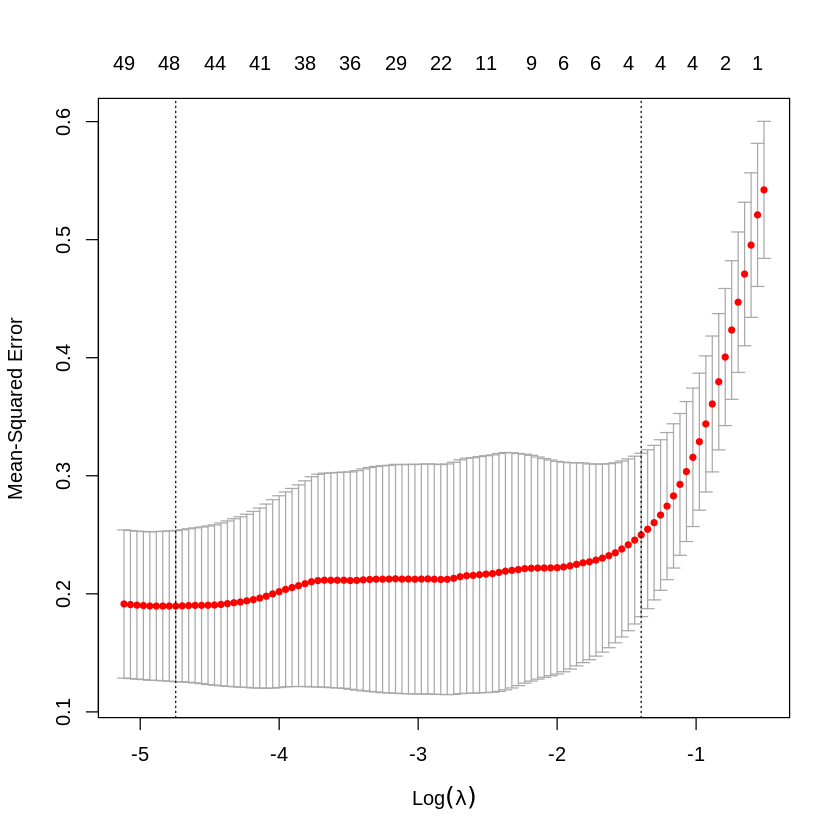

In [437]:
zx <- get_lasso(X,Y,names(Y)[5])
extract.coef(zx)

In [429]:
zx


Call:  cv.glmnet(x = as.matrix(X), y = as.matrix(Y[i]), nfolds = 10) 

Measure: Mean-Squared Error 

    Lambda Measure     SE Nonzero
min 0.0432  0.8023 0.2930      34
1se 0.4030  1.0888 0.2592       8

Loading required package: reshape2


Attaching package: 'reshape2'


The following object is masked from 'package:tidyr':

    smiths


No id variables; using all as measure variables



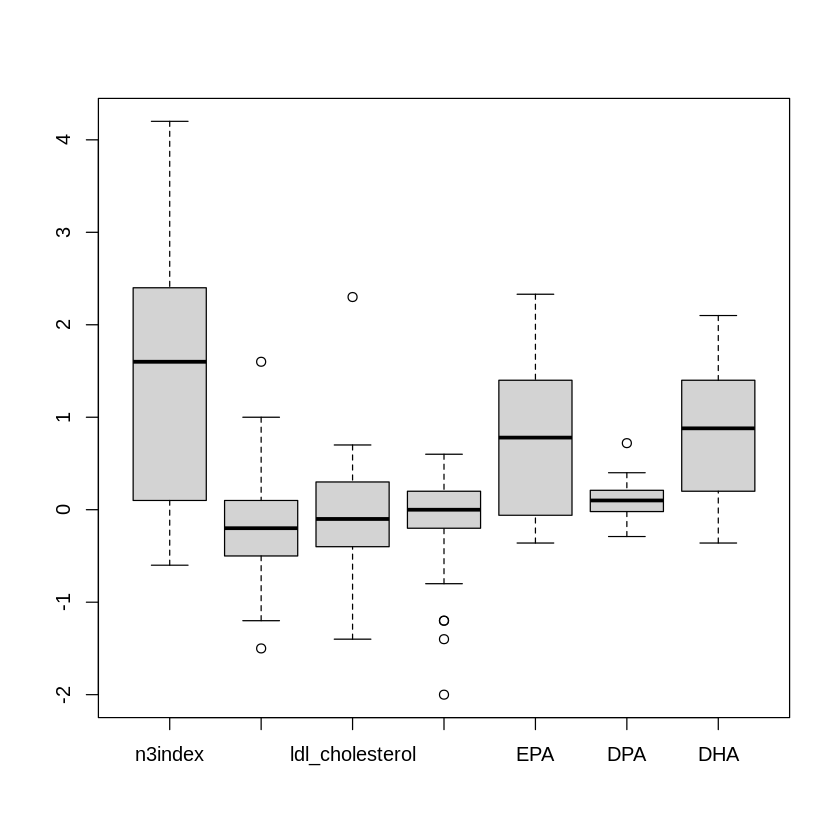

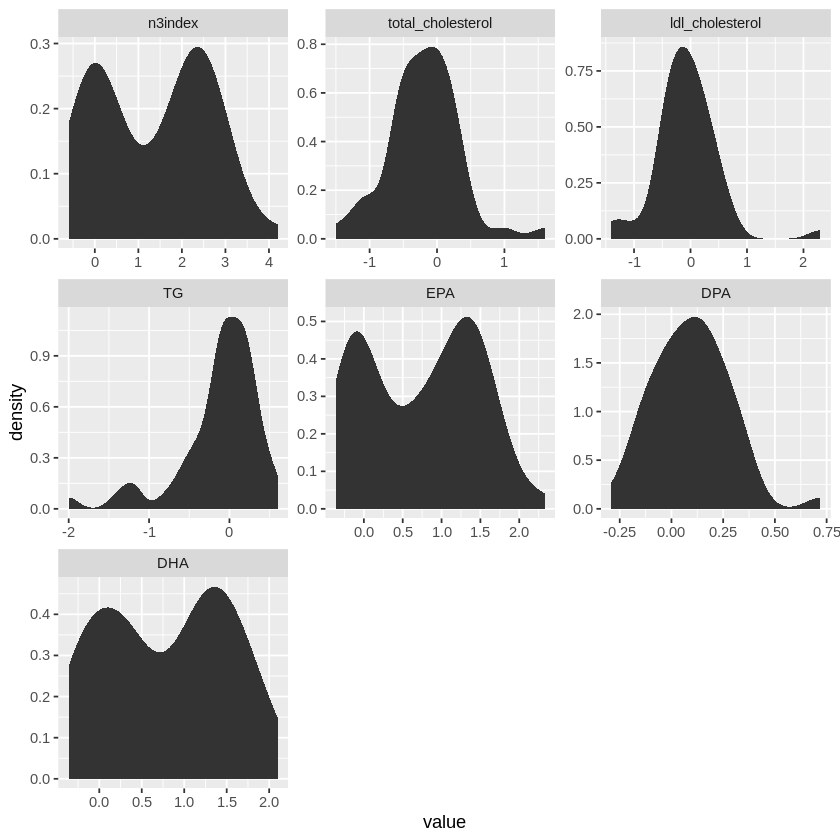

In [15]:
require(reshape2)
boxplot(Y)
melt.diff <- melt(Y)
ggplot(data = melt.diff, aes(x = value)) + 
  stat_density() +
facet_wrap(~variable, scales = "free") + theme_set(theme_cowplot())

Installing package into '/data/xiaoral/lib/R/x86_64-redhat-linux-gnu-library/3.6'
(as 'lib' is unspecified)



In [370]:
    cv_fit <- glinternet.cv(X, unlist(Y['n3index']), numLevels)

In [337]:
    i_1Std <- which(cv_fit$lambdaHat1Std == cv_fit$lambda)
    coefs <- coef(cv_fit$glinternetFit)[[i_1Std]]
    i_num <- sapply(X, is.numeric)
    idx_num <- (1:length(i_num))[i_num]
    idx_cat <- (1:length(i_num))[!i_num]

In [338]:
coefs

$mainEffects
$mainEffects$cat
NULL

$mainEffects$cont
[1] 465 564


$mainEffectsCoef
$mainEffectsCoef$cat
list()

$mainEffectsCoef$cont
$mainEffectsCoef$cont[[1]]
[1] 0.3799151

$mainEffectsCoef$cont[[2]]
[1] -0.06712205



$interactions
$interactions$catcat
NULL

$interactions$contcont
NULL

$interactions$catcont
NULL


$interactionsCoef
$interactionsCoef$catcat
list()

$interactionsCoef$contcont
list()

$interactionsCoef$catcont
list()

In [384]:
    i_1Std <- 21
    coefs <- coef(cv_fit$glinternetFit)[[i_1Std]]
    i_num <- sapply(X, is.numeric)
    idx_num <- (1:length(i_num))[i_num]
    idx_cat <- (1:length(i_num))[!i_num]

names(numLevels)[idx_num[coefs$interactions$catcont[,2]]]

character(0)

Loading required package: reshape2


Attaching package: 'reshape2'


The following object is masked from 'package:tidyr':

    smiths


No id variables; using all as measure variables



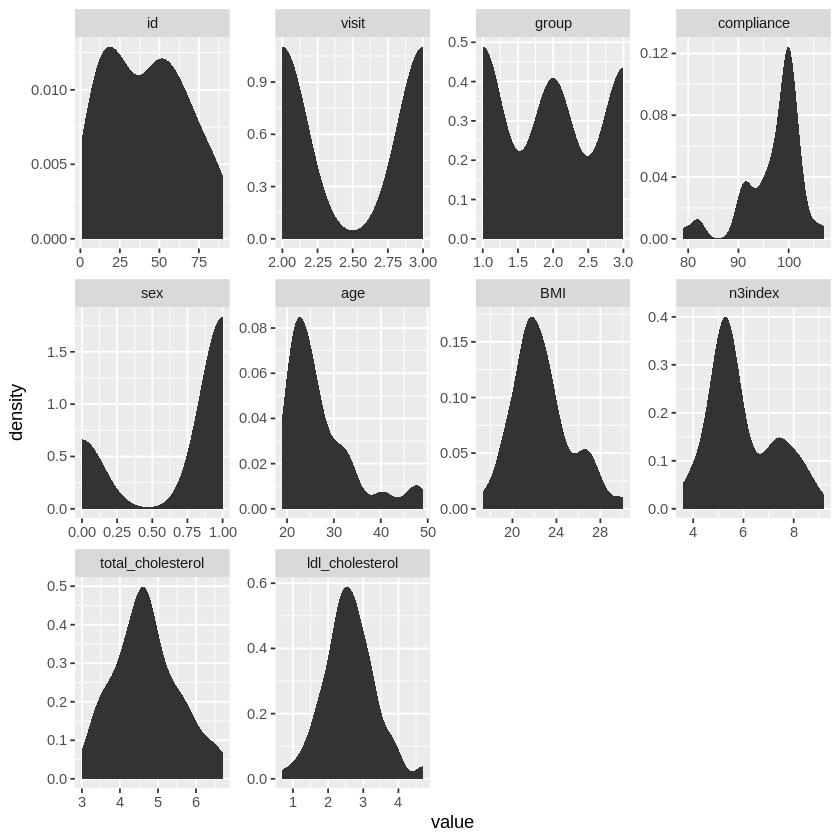

In [9]:
require(reshape2)

melt.diff <- melt(dat_sub[,1:10],)
ggplot(data = melt.diff, aes(x = value)) + 
  stat_density() +
facet_wrap(~variable, scales = "free") + theme_set(theme_cowplot())

In [8]:
head(dat_sub[,1:10])

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.3966  0.8426  1.0476  1.0970  1.2729  2.5013 